In [2]:
pip install optuna catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score

np.random.seed(42)
random.seed(42)

Поскольку побить бустинг другими алгоритмами не удалось, решили в течение этого чекпоинта поработать над способами векторизации текста. Кажется, это тот аспект, который может позволить нам прирасти в качестве модели. В остальном пайплайн остается тот же: поддержка GPU катбустом позволяет достаточно хорошо тюнить модель на всём корпусе прибегая к помощи оптюны. 

На прошлой итерации я уже пытался потюнить бустинг и в итоге пришёл к тому, что векторизация сырого текста под капотом работает значительно быстрее из-за GPU, а в качестве не уступает в ручную предобработанному тексту даже при базовых настройках работы с текстом. Поэтому планирую попробовать различные доступные способы векторизации чтобы улучшить модель. Подробнее: https://catboost.ai/en/docs/concepts/algorithm-main-stages_text-to-numeric
  

Наиболее интересно попробовать использовать наивного Байеса и BM25 вместо дефолтных настроек

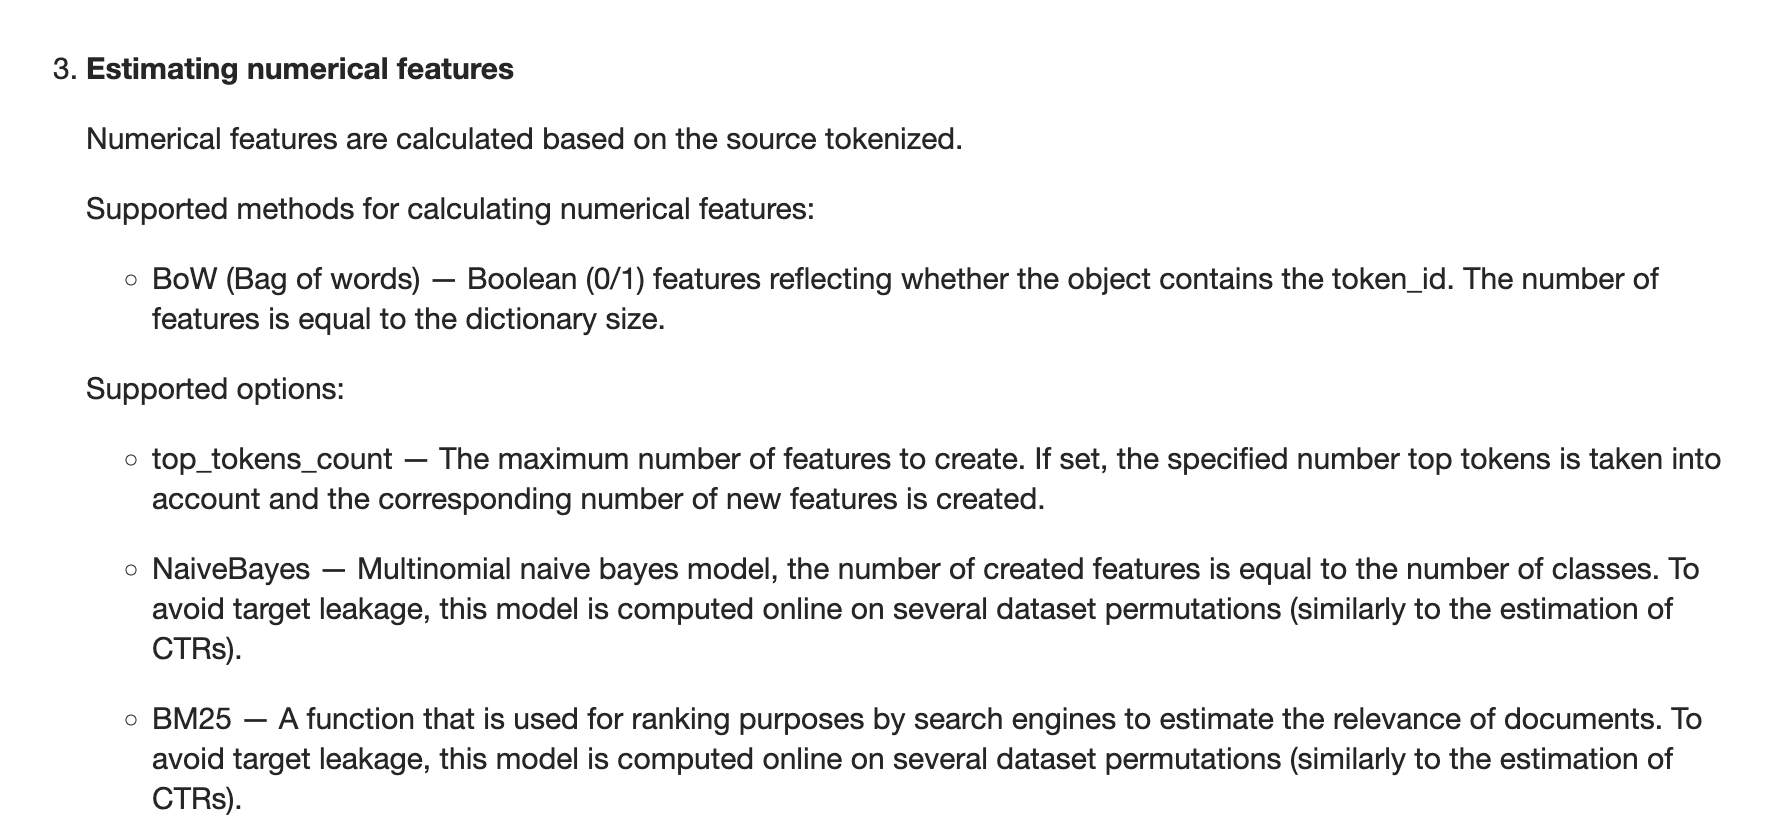

In [15]:
df_train = pd.read_csv('train.csv', index_col=0) 
df_test = pd.read_csv('test.csv', index_col=0) 

In [16]:
df_train

,text,label,text_lemmatized
12704,why don’t trade your btc to earn weekly rathe...,1,"['dont', 'trade', 'btc', 'earn', 'weekly', 'ra..."
1199027,"i’ll be honest, i didn’t see it sinking this ...",1,"['ill', 'honest', 'didnt', 'see', 'sinking', '..."
858781,-x needs to break 38 to hit 4 no shit lol,1,"['x', 'need', 'break', 'hit', 'shit', 'lol']"
972002,it's gonna be an all nighter ha?,1,"['gon', 'na', 'nighter', 'ha']"
1281138,y’all should just come to cro.x,2,"['yall', 'come', 'crox']"
...,...,...,...
275576,"•which way, western man? btc vs. cbdc.",1,"['way', 'western', 'man', 'btc', 'v', 'cbdc']"
121751,i love converting random micro denominations ...,1,"['love', 'converting', 'random', 'micro', 'den..."
336428,finally figured out to be greedy when those ar...,2,"['finally', 'figured', 'greedy', 'fearful', 'f..."
243449,didn’t you say your going to bed ??,2,"['didnt', 'say', 'going', 'bed']"


In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_train[['text']],
                                                    df_train['label'],
                                                    test_size=0.3)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928801 entries, 12704 to 1025907
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             928801 non-null  object
 1   label            928801 non-null  int64 
 2   text_lemmatized  928801 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.3+ MB


In [19]:
X_test = df_test[['text']]
y_test = df_test['label']

In [20]:
text_features = ['text']

In [21]:
train_pool = Pool(
        X_train, 
        y_train, 
        text_features=text_features,
        feature_names=text_features
    )
valid_pool = Pool(
        X_val, 
        y_val, 
        text_features=text_features,
        feature_names=text_features
    )

In [24]:
def objective(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "depth": trial.suggest_int("depth", 2, 6),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }


    model = CatBoostClassifier(**catboost_params) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=60)

[I 2023-02-27 21:30:18,135] A new study created in memory with name: no-name-69025d98-78cb-4d29-ad1a-4dcec591692d


0:	learn: 0.4602172	test: 0.4727239	best: 0.4727239 (0)	total: 70.4ms	remaining: 1m 3s
bestTest = 0.472723918
bestIteration = 0
Shrink model to first 1 iterations.


[I 2023-02-27 21:30:45,527] Trial 0 finished with value: 0.47272391804302943 and parameters: {'iterations': 899, 'depth': 6, 'min_data_in_leaf': 660, 'learning_rate': 0.020588654394115426, 'early_stopping_rounds': 173}. Best is trial 0 with value: 0.47272391804302943.


0:	learn: 0.4602172	test: 0.4727239	best: 0.4727239 (0)	total: 70.8ms	remaining: 1m 15s
300:	learn: 0.4662343	test: 0.4791988	best: 0.4791988 (300)	total: 11.9s	remaining: 30.4s
600:	learn: 0.4704379	test: 0.4830925	best: 0.4830925 (600)	total: 22.1s	remaining: 17.2s
900:	learn: 0.4726126	test: 0.4848087	best: 0.4849143 (893)	total: 34.6s	remaining: 6.45s
1068:	learn: 0.4736444	test: 0.4854409	best: 0.4854409 (1068)	total: 41.6s	remaining: 0us
bestTest = 0.4854409378
bestIteration = 1068


[I 2023-02-27 21:31:52,429] Trial 1 finished with value: 0.48544093779900704 and parameters: {'iterations': 1069, 'depth': 6, 'min_data_in_leaf': 273, 'learning_rate': 0.03233661695729228, 'early_stopping_rounds': 457}. Best is trial 1 with value: 0.48544093779900704.


В качестве ключевой метрики исопльзуем macro f1. Базовая модель даёт ~0.485. Попробуем превзойти это значение

Попробуем добавить униграммы, биграммы и приведение к нижнему регистру. Словарь ограничим 50к словами, а минимальное вхождение слова положим равным 10. (Всё это условно и при большом желании можно позаниматься микротюнингом и пошатать и эти границы)

In [32]:
def objective_custom_1(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "1"
        }],
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_1, n_trials=15, timeout=60)

[I 2023-02-27 21:34:11,843] A new study created in memory with name: no-name-762b2feb-c258-475e-82a5-80b58fb589b1


0:	learn: 0.4268384	test: 0.4369393	best: 0.4369393 (0)	total: 47.1ms	remaining: 2m 21s
300:	learn: 0.4671186	test: 0.4851759	best: 0.4852026 (297)	total: 6.59s	remaining: 59s
600:	learn: 0.4700748	test: 0.4874062	best: 0.4876025 (531)	total: 14.6s	remaining: 58.1s
900:	learn: 0.4718002	test: 0.4880852	best: 0.4884172 (815)	total: 20.5s	remaining: 47.7s
1200:	learn: 0.4732870	test: 0.4898603	best: 0.4899031 (1198)	total: 28s	remaining: 41.9s
1500:	learn: 0.4745032	test: 0.4905014	best: 0.4906188 (1439)	total: 35.5s	remaining: 35.4s
1800:	learn: 0.4756554	test: 0.4907992	best: 0.4912518 (1670)	total: 42.3s	remaining: 28.1s
2100:	learn: 0.4769539	test: 0.4919176	best: 0.4920058 (2084)	total: 52.9s	remaining: 22.6s
2400:	learn: 0.4781196	test: 0.4923255	best: 0.4923255 (2400)	total: 1m 1s	remaining: 15.2s
2700:	learn: 0.4790288	test: 0.4929403	best: 0.4929403 (2700)	total: 1m 10s	remaining: 7.68s
2996:	learn: 0.4801079	test: 0.4937097	best: 0.4937097 (2996)	total: 1m 17s	remaining: 0us
be

[I 2023-02-27 21:36:04,982] Trial 0 finished with value: 0.49370971003552705 and parameters: {'iterations': 2997, 'depth': 3, 'min_data_in_leaf': 62, 'learning_rate': 0.08973634857911625, 'early_stopping_rounds': 638}. Best is trial 0 with value: 0.49370971003552705.


Приросли на почти сотую, неплохо, попробуем добавить 3-граммы

In [34]:
def objective_custom_2(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "3"
        }],
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_2, n_trials=15, timeout=60)

[I 2023-02-27 21:37:18,240] A new study created in memory with name: no-name-35d1d4c6-fb41-45f1-938e-b20239b48188


0:	learn: 0.3995264	test: 0.4053067	best: 0.4053067 (0)	total: 41.6ms	remaining: 1m 44s
300:	learn: 0.4623588	test: 0.4803911	best: 0.4909685 (2)	total: 5.78s	remaining: 42.3s
bestTest = 0.4909684924
bestIteration = 2
Shrink model to first 3 iterations.


[I 2023-02-27 21:37:58,135] Trial 0 finished with value: 0.4909684923649505 and parameters: {'iterations': 2505, 'depth': 2, 'min_data_in_leaf': 629, 'learning_rate': 0.05696002507388703, 'early_stopping_rounds': 554}. Best is trial 0 with value: 0.4909684923649505.


0:	learn: 0.4545555	test: 0.4714291	best: 0.4714291 (0)	total: 69.7ms	remaining: 1m 22s
300:	learn: 0.4720219	test: 0.4890393	best: 0.4890393 (300)	total: 13.1s	remaining: 38.2s
600:	learn: 0.4754214	test: 0.4905985	best: 0.4909119 (578)	total: 28.6s	remaining: 27.5s
900:	learn: 0.4789424	test: 0.4933302	best: 0.4934574 (883)	total: 43.2s	remaining: 13.3s
1178:	learn: 0.4819889	test: 0.4948184	best: 0.4949232 (1163)	total: 53.4s	remaining: 0us
bestTest = 0.4949232253
bestIteration = 1163
Shrink model to first 1164 iterations.


[I 2023-02-27 21:39:25,046] Trial 1 finished with value: 0.49492322534713296 and parameters: {'iterations': 1179, 'depth': 6, 'min_data_in_leaf': 973, 'learning_rate': 0.0803187160844681, 'early_stopping_rounds': 104}. Best is trial 1 with value: 0.49492322534713296.


Ещё 2 тысячные, пойдет

Также попробуем использовать чуть более сложный токенайзер

In [38]:
def objective_custom_3(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        },
        {
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "3"
        }],
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [39]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_3, n_trials=15, timeout=60)

[I 2023-02-27 21:40:47,171] A new study created in memory with name: no-name-7978c334-0f0f-424b-8c7c-ed571c0bbef2


0:	learn: 0.4549143	test: 0.4715856	best: 0.4715856 (0)	total: 83.3ms	remaining: 3m 46s
300:	learn: 0.4632581	test: 0.4799319	best: 0.4799329 (299)	total: 14.8s	remaining: 1m 58s
600:	learn: 0.4683240	test: 0.4853631	best: 0.4853631 (600)	total: 26.6s	remaining: 1m 33s
900:	learn: 0.4708026	test: 0.4873465	best: 0.4873577 (889)	total: 38.1s	remaining: 1m 16s
1200:	learn: 0.4723141	test: 0.4881666	best: 0.4882269 (1188)	total: 49.8s	remaining: 1m 2s
1500:	learn: 0.4736543	test: 0.4889477	best: 0.4890414 (1460)	total: 1m	remaining: 49.2s
1800:	learn: 0.4749492	test: 0.4895440	best: 0.4895845 (1792)	total: 1m 10s	remaining: 36s
2100:	learn: 0.4759672	test: 0.4901497	best: 0.4901612 (2099)	total: 1m 21s	remaining: 24s
2400:	learn: 0.4770747	test: 0.4908753	best: 0.4909517 (2382)	total: 1m 33s	remaining: 12.3s
2700:	learn: 0.4780243	test: 0.4918044	best: 0.4918044 (2700)	total: 1m 45s	remaining: 626ms
2716:	learn: 0.4780685	test: 0.4918797	best: 0.4918989 (2715)	total: 1m 46s	remaining: 0us

[I 2023-02-27 21:43:07,202] Trial 0 finished with value: 0.49189894383506716 and parameters: {'iterations': 2717, 'depth': 7, 'min_data_in_leaf': 885, 'learning_rate': 0.019182180289384836, 'early_stopping_rounds': 477}. Best is trial 0 with value: 0.49189894383506716.


Получилось чуть хуже, значит, время переходить дальше. Попробую генерить фичи используя наивного Байеса

In [42]:
def objective_custom_4(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        },
        {
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "10",
            "gram_order" : "3"
        }],
        "feature_processing" : {
            "default" : [{
                "dictionaries_names" : ["BiGram", "Word", "3-Gram"],
                "feature_calcers" : ["BoW"],
                "tokenizers_names" : ["Space"]
            }, {
                "dictionaries_names" : ["Word", "BiGram", "3-Gram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            }],
        }
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_4, n_trials=15, timeout=90)

[I 2023-02-27 21:47:20,083] A new study created in memory with name: no-name-beb4bb1a-9cbe-4ee2-abb5-6b831ef56486


0:	learn: 0.3726802	test: 0.3790959	best: 0.3790959 (0)	total: 54.1ms	remaining: 2m 3s
300:	learn: 0.4470389	test: 0.4673537	best: 0.4673537 (300)	total: 9.79s	remaining: 1m 4s
600:	learn: 0.4707417	test: 0.4912680	best: 0.4912680 (600)	total: 17.8s	remaining: 49.7s
900:	learn: 0.4761070	test: 0.4966606	best: 0.4966822 (895)	total: 26.2s	remaining: 40.2s
1200:	learn: 0.4779046	test: 0.4985200	best: 0.4985529 (1197)	total: 34.8s	remaining: 31.3s
1500:	learn: 0.4793797	test: 0.5002562	best: 0.5002917 (1499)	total: 42s	remaining: 21.8s
1800:	learn: 0.4801840	test: 0.5011375	best: 0.5011375 (1800)	total: 50.5s	remaining: 13.5s
2100:	learn: 0.4807387	test: 0.5018063	best: 0.5018443 (2091)	total: 58.8s	remaining: 5.07s
2281:	learn: 0.4810560	test: 0.5022359	best: 0.5022462 (2271)	total: 1m 3s	remaining: 0us
bestTest = 0.502246168
bestIteration = 2271
Shrink model to first 2272 iterations.


[I 2023-02-27 21:49:15,647] Trial 0 finished with value: 0.5022461679912896 and parameters: {'iterations': 2282, 'depth': 2, 'min_data_in_leaf': 607, 'learning_rate': 0.013965028330376442, 'early_stopping_rounds': 898}. Best is trial 0 with value: 0.5022461679912896.


Смогли пробить 0.5, очень здорово

Попробуем вместо Баеса BM25 (аналог tf-idf, где токен вместо слова и класс вместо документа)

In [46]:
def objective_custom_5(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        },
        {
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "5",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "5",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "5",
            "gram_order" : "3"
        }],
        "feature_processing" : {
            "default" : [{
                "dictionaries_names" : ["BiGram", "Word", "3-Gram"],
                "feature_calcers" : ["BoW"],
                "tokenizers_names" : ["Space"]
            }, {
                "dictionaries_names" : ["Word", "BiGram", "3-Gram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            }],
        }
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_5, n_trials=15, timeout=90)

[I 2023-02-27 21:54:19,809] A new study created in memory with name: no-name-ccb00eae-0385-486d-b25c-7689e094fea8


0:	learn: 0.2950841	test: 0.2845728	best: 0.2845728 (0)	total: 59.2ms	remaining: 1m 35s
300:	learn: 0.3209262	test: 0.3093388	best: 0.3093388 (300)	total: 12.3s	remaining: 53.4s
600:	learn: 0.3576915	test: 0.3518894	best: 0.3518894 (600)	total: 23.7s	remaining: 39.9s
900:	learn: 0.3755046	test: 0.3711153	best: 0.3711153 (900)	total: 36.7s	remaining: 28.9s
1200:	learn: 0.3875266	test: 0.3842041	best: 0.3842041 (1200)	total: 47.8s	remaining: 16.4s
1500:	learn: 0.3973500	test: 0.3946126	best: 0.3946126 (1500)	total: 59.3s	remaining: 4.38s
1611:	learn: 0.4004829	test: 0.3978928	best: 0.3979131 (1610)	total: 1m 2s	remaining: 0us
bestTest = 0.3979131197
bestIteration = 1610
Shrink model to first 1611 iterations.


[I 2023-02-27 21:56:13,849] Trial 0 finished with value: 0.3979131196982313 and parameters: {'iterations': 1612, 'depth': 6, 'min_data_in_leaf': 657, 'learning_rate': 0.02038655468167428, 'early_stopping_rounds': 838}. Best is trial 0 with value: 0.3979131196982313.


Это совсем не взлетело

Попробуем в качестве отдельных признаков добавить слова которые встречаются чаще 5к раз

In [58]:
def objective_custom_6(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        },
        {
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "3"
        }],
        "feature_processing" : {
            "default" : [
            {"dictionaries_names" : ["Word"],
                "feature_calcers" : ["BoW:top_tokens_count=5000"],
                "tokenizers_names" : ["Space"]}
            ],
        }
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_6, n_trials=15, timeout=90)

[I 2023-02-27 22:06:07,566] A new study created in memory with name: no-name-25a1d486-7549-4ed0-8f0f-7bdcb8022370


0:	learn: 0.2755221	test: 0.2763186	best: 0.2763186 (0)	total: 47.1ms	remaining: 1m 40s
300:	learn: 0.3665075	test: 0.3666366	best: 0.3666366 (300)	total: 9.9s	remaining: 1m
600:	learn: 0.3946529	test: 0.3955024	best: 0.3955024 (600)	total: 16.6s	remaining: 42.1s
900:	learn: 0.4100520	test: 0.4097516	best: 0.4097516 (900)	total: 24.7s	remaining: 33.6s
1200:	learn: 0.4210677	test: 0.4194974	best: 0.4194974 (1200)	total: 32.6s	remaining: 25.1s
1500:	learn: 0.4292604	test: 0.4263855	best: 0.4263855 (1500)	total: 39.3s	remaining: 16.4s
1800:	learn: 0.4355281	test: 0.4325849	best: 0.4325859 (1799)	total: 47.4s	remaining: 8.59s
2100:	learn: 0.4403644	test: 0.4370002	best: 0.4370621 (2096)	total: 54s	remaining: 668ms
2126:	learn: 0.4408816	test: 0.4373899	best: 0.4374164 (2122)	total: 54.7s	remaining: 0us
bestTest = 0.4374163694
bestIteration = 2122
Shrink model to first 2123 iterations.


[I 2023-02-27 22:07:26,540] Trial 0 finished with value: 0.43741636939768597 and parameters: {'iterations': 2127, 'depth': 5, 'min_data_in_leaf': 381, 'learning_rate': 0.09984185155677924, 'early_stopping_rounds': 357}. Best is trial 0 with value: 0.43741636939768597.


0:	learn: 0.2808571	test: 0.2818806	best: 0.2818806 (0)	total: 58.1ms	remaining: 2m 23s
300:	learn: 0.2825942	test: 0.2830331	best: 0.2868720 (95)	total: 12.2s	remaining: 1m 27s
600:	learn: 0.3199242	test: 0.3199601	best: 0.3199601 (600)	total: 27.5s	remaining: 1m 25s
900:	learn: 0.3375911	test: 0.3378364	best: 0.3378364 (900)	total: 43.2s	remaining: 1m 15s
1200:	learn: 0.3492441	test: 0.3491731	best: 0.3491731 (1200)	total: 56s	remaining: 59.1s
1500:	learn: 0.3585958	test: 0.3584181	best: 0.3584365 (1499)	total: 1m 8s	remaining: 43.9s
1800:	learn: 0.3667391	test: 0.3662989	best: 0.3662989 (1800)	total: 1m 20s	remaining: 29.8s
2100:	learn: 0.3733609	test: 0.3731169	best: 0.3731423 (2099)	total: 1m 29s	remaining: 15.6s
2400:	learn: 0.3800746	test: 0.3801787	best: 0.3801787 (2400)	total: 1m 38s	remaining: 2.75s
2467:	learn: 0.3812875	test: 0.3814668	best: 0.3814668 (2467)	total: 1m 40s	remaining: 0us
bestTest = 0.3814667516
bestIteration = 2467


[I 2023-02-27 22:09:30,664] Trial 1 finished with value: 0.38146675157596444 and parameters: {'iterations': 2468, 'depth': 7, 'min_data_in_leaf': 199, 'learning_rate': 0.012128144899720365, 'early_stopping_rounds': 785}. Best is trial 0 with value: 0.43741636939768597.


Так, здесь тоже прирасти не получилось. Тогда признаем лучшим эксперимент №4, тюним параметры побольше и замеряем качество на настоящем тесте. Предыдущая модель давала **0.496**

In [70]:
def objective_custom_final(trial):

    catboost_params = {
        "loss_function": 'MultiClass',
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'task_type': 'GPU',
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 1000),
        'eval_metric': 'TotalF1:average=Macro',
        'verbose': 300
    }
    text_processing = {
        "tokenizers" : [{
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        },
        {
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "lowercasing": "True",
            "delimiter" : " "
        }],
    
        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "2"
        }, {
            "dictionary_id" : "Word",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "1"
        },{
            "dictionary_id" : "3-Gram",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "100",
            "gram_order" : "3"
        }],
        "feature_processing" : {
            "default" : [{
                "dictionaries_names" : ["BiGram", "Word", "3-Gram"],
                "feature_calcers" : ["BoW"],
                "tokenizers_names" : ["Space"]
            }, {
                "dictionaries_names" : ["Word", "BiGram", "3-Gram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            }],
        }
    }


    model = CatBoostClassifier(**catboost_params, text_processing=text_processing) 
    model.fit(train_pool, eval_set=valid_pool)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')

    return f1

In [71]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_custom_4, n_trials=15, timeout=360)

[I 2023-02-27 22:25:02,864] A new study created in memory with name: no-name-35feda45-ff87-40d0-883a-ed09f7190ed7


0:	learn: 0.4357911	test: 0.4544049	best: 0.4544049 (0)	total: 85.4ms	remaining: 3m 25s
300:	learn: 0.4808752	test: 0.5013874	best: 0.5014012 (299)	total: 13.8s	remaining: 1m 36s
600:	learn: 0.4842874	test: 0.5045535	best: 0.5046351 (580)	total: 25.1s	remaining: 1m 15s
900:	learn: 0.4859341	test: 0.5053787	best: 0.5054868 (893)	total: 36.3s	remaining: 1m
1200:	learn: 0.4873074	test: 0.5060780	best: 0.5062611 (1157)	total: 47.5s	remaining: 47.5s
1500:	learn: 0.4889480	test: 0.5069060	best: 0.5069060 (1500)	total: 58.6s	remaining: 35.2s
1800:	learn: 0.4901238	test: 0.5074602	best: 0.5075643 (1671)	total: 1m 9s	remaining: 23.2s
2100:	learn: 0.4913204	test: 0.5077575	best: 0.5081032 (2016)	total: 1m 20s	remaining: 11.5s
2400:	learn: 0.4922566	test: 0.5084825	best: 0.5086303 (2360)	total: 1m 29s	remaining: 37.4ms
2401:	learn: 0.4922548	test: 0.5084931	best: 0.5086303 (2360)	total: 1m 29s	remaining: 0us
bestTest = 0.5086303407
bestIteration = 2360
Shrink model to first 2361 iterations.


[I 2023-02-27 22:27:26,749] Trial 0 finished with value: 0.5086303406933194 and parameters: {'iterations': 2402, 'depth': 5, 'min_data_in_leaf': 567, 'learning_rate': 0.03870518643427813, 'early_stopping_rounds': 963}. Best is trial 0 with value: 0.5086303406933194.


0:	learn: 0.4475263	test: 0.4656929	best: 0.4656929 (0)	total: 148ms	remaining: 6m 23s
300:	learn: 0.4921905	test: 0.5072287	best: 0.5074770 (244)	total: 21.8s	remaining: 2m 46s
600:	learn: 0.4988708	test: 0.5092282	best: 0.5094105 (521)	total: 41.2s	remaining: 2m 17s
900:	learn: 0.5044641	test: 0.5103519	best: 0.5103618 (896)	total: 59.3s	remaining: 1m 51s
1200:	learn: 0.5091320	test: 0.5112894	best: 0.5114781 (1099)	total: 1m 18s	remaining: 1m 31s
1500:	learn: 0.5139317	test: 0.5121148	best: 0.5124079 (1483)	total: 1m 36s	remaining: 1m 10s
1800:	learn: 0.5183874	test: 0.5125148	best: 0.5126645 (1790)	total: 1m 56s	remaining: 51.4s
2100:	learn: 0.5223890	test: 0.5126771	best: 0.5130758 (1937)	total: 2m 15s	remaining: 32s
2400:	learn: 0.5267469	test: 0.5135880	best: 0.5137821 (2357)	total: 2m 34s	remaining: 12.7s
2597:	learn: 0.5292933	test: 0.5138892	best: 0.5138904 (2518)	total: 2m 47s	remaining: 0us
bestTest = 0.5138903787
bestIteration = 2518
Shrink model to first 2519 iterations.


[I 2023-02-27 22:31:11,671] Trial 1 finished with value: 0.5138903787228823 and parameters: {'iterations': 2598, 'depth': 8, 'min_data_in_leaf': 538, 'learning_rate': 0.0907049133503472, 'early_stopping_rounds': 668}. Best is trial 1 with value: 0.5138903787228823.


In [72]:
study.best_trial.params

{'iterations': 2598,
 'depth': 8,
 'min_data_in_leaf': 538,
 'learning_rate': 0.0907049133503472,
 'early_stopping_rounds': 668}

In [74]:
catboost_params ={
    'iterations': 2598,
    'depth': 8,
    'min_data_in_leaf': 538,
    'learning_rate': 0.0907049133503472,
    'eval_metric': 'TotalF1:average=Macro',
    "loss_function": 'MultiClass',
    'task_type': 'GPU',
    'verbose': 300,
    'early_stopping_rounds': 668}

Финальная модель и её метрики на тесте

In [75]:
model = CatBoostClassifier(**catboost_params) 
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.4688847	test: 0.4814049	best: 0.4814049 (0)	total: 94.5ms	remaining: 4m 5s
300:	learn: 0.4758695	test: 0.4860353	best: 0.4861209 (278)	total: 15.7s	remaining: 1m 59s
600:	learn: 0.4834980	test: 0.4901324	best: 0.4901498 (599)	total: 28.9s	remaining: 1m 35s
900:	learn: 0.4895234	test: 0.4928216	best: 0.4928216 (900)	total: 42.4s	remaining: 1m 19s
1200:	learn: 0.4945462	test: 0.4946860	best: 0.4946860 (1200)	total: 55.7s	remaining: 1m 4s
1500:	learn: 0.4997119	test: 0.4961705	best: 0.4961893 (1499)	total: 1m 9s	remaining: 50.7s
1800:	learn: 0.5049067	test: 0.4971630	best: 0.4971630 (1800)	total: 1m 22s	remaining: 36.7s
2100:	learn: 0.5095711	test: 0.4980742	best: 0.4981835 (2093)	total: 1m 36s	remaining: 22.9s
2400:	learn: 0.5140266	test: 0.4986331	best: 0.4989712 (2309)	total: 1m 51s	remaining: 9.13s
2597:	learn: 0.5165590	test: 0.4992061	best: 0.4992882 (2549)	total: 1m 59s	remaining: 0us
bestTest = 0.4992881924
bestIteration = 2549
Shrink model to first 2550 iterations.


In [76]:
f1_macro = f1_score(y_test, model.predict(X_test), average='macro')
f1_micro = f1_score(y_test, model.predict(X_test), average='micro')

In [77]:
f1_macro

0.4969744916694925

In [69]:
f1_micro

0.6089062397942009

Результат почти польностью идентичен предыдущей версии модели. В целом, это не новость, что достаточно хорошо настроенный бустинг сложно побить. Тем более, катбуст славится тем, что зачастую очень хорошо работает из коробки

In [78]:
from sklearn.metrics import roc_auc_score

In [79]:
preds = model.predict(X_test)

In [80]:
probs = model.predict_proba(X_test)

In [81]:
macro_auc = roc_auc_score(y_test, probs, multi_class='ovo')
micro_auc = roc_auc_score(y_test, probs, multi_class='ovr')

In [82]:
macro_auc

0.7398473034149854

In [83]:
micro_auc

0.7451956454425549

In [84]:
from sklearn.metrics import precision_score, recall_score

In [85]:
macro_precision_score = precision_score(y_test, preds, average='micro')
micro_precision_score = precision_score(y_test, preds, average='macro')

In [86]:
macro_precision_score

0.6099663868079526

In [87]:
micro_precision_score

0.589665208415975

In [88]:
macro_recall_score = recall_score(y_test, preds, average='micro')
micro_recall_score = recall_score(y_test, preds, average='macro')

In [89]:
macro_recall_score

0.6099663868079526

In [90]:
micro_recall_score

0.48204034053233474

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [92]:
cm = confusion_matrix(y_test, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

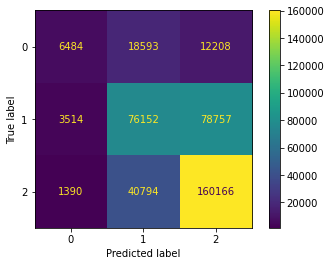

In [93]:
disp.plot()
plt.show()

In [94]:
cm = confusion_matrix(y_test, preds, labels=model.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

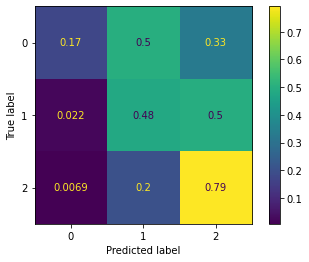

In [95]:
disp.plot()
plt.show()

In [96]:
df_train.label.value_counts()

2    471774
1    370235
0     86792
Name: label, dtype: int64

Резюмируя, на этой стадии проекта удалось совсем немного улучшить качество модели, что, в целом, ожидаемо. 